## Table of content  
* [Workflow for solving softmax regression](#section_1)  
* [Read the dataset](#section_2)   
* [How Softmax function Works ?](#section_3)     
* [How Cross Entropy Loss works ?](#section_4)   
* [Training Model](#section_5)   
* [Evaluation of Model](#section_6)   
    * Accuracy
* [Visualization](#section_7)   
    * Predicted cporrectly  
    
    * Predicted Wrong

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

## Workflow for solving Softmax regression  
<a id = 'section_1'></a>

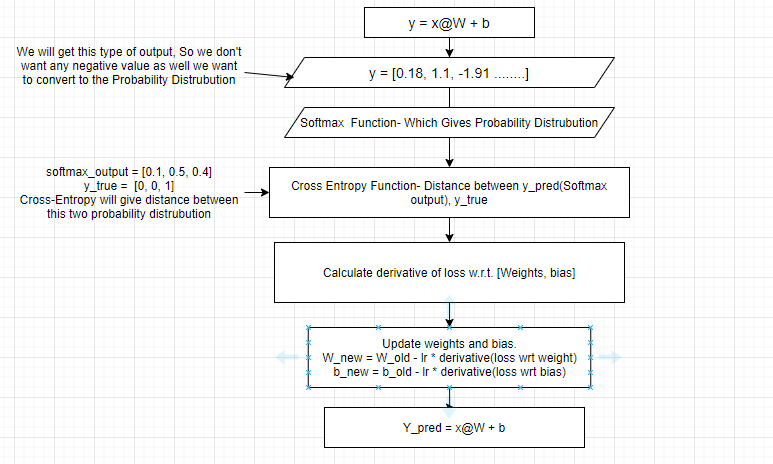

## Reading the Dataset  
<a id = 'section_2'></a>

In [ ]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [ ]:
df.head()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train,  y_test = train_test_split(df.iloc[:, 1:], df['label'], test_size = 0.25)

In [ ]:
batch_size = 32

# # Reshape dataset to flat array with dim 1
# x_train, y_train, x_test, y_test = mnist_train[0].reshape(60000,784), mnist_train[1], mnist_test[0].reshape(10000,784), mnist_test[1]

x_train = tf.cast(x_train, dtype = 'float32')
x_test = tf.cast(x_test, dtype = 'float32')
y_train = tf.cast(y_train, dtype='int32')
y_test = tf.cast(y_test, dtype='int32')

In [ ]:
# Let's have a look at out dataset

In [ ]:
x_train, y_train

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.reshape(x_train[i], (28,28)), cmap=plt.cm.binary)
    plt.title(f'label {y_train[i]}')
plt.show()

By using tensorflow, we convert dataset in the batch format.  
It is always prefered to use scaled dataset while passing to machine learning algorithm, So we will divide dataset with  255.0

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train/255.0, y_train)).batch(batch_size).shuffle(len(x_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test/255.0, y_test)).batch(batch_size).shuffle(len(x_train))

In [ ]:
# In this way tensorflow store our dataset in the batch format
for x, y_label in train_ds:
    print(y_label)
    break

## Softmax Function  
<a id = 'section_3'></a>  
We know the linear equation y = wX + b ,
We get output of the above equation, Which need to be converted into probability so that We can predict the class of image.      
We need to convert into probability distrubution, We can do this with softmax function

$$ y_i = {\exp(y_i) \over \sum_{i}^{n} exp(y_i)}$$  
As we know sum of the probabilities will be equal to one.  
where /inline:$$ \sum_{i}^{n} y_i = 1$$  

Intuition behind Softmax,  
We will solve our linear equation $$ y_{pred} = X W + b $$  
Now, We want predicted value as a probability of a class. So that we can easily classify image.  

In [ ]:
def softmax(y_pred):
    return tf.exp(y_pred)/tf.reduce_sum(tf.exp(y_pred))

## Cross-Entropy  
<a id = 'section_4'></a>


Cross entropy loss function.  
By using softmax function we calculated probability distrubution. Let's explain this with an example.  
Assume we are predicting three classes (dog, cat, mouse)  
probability_distrubution of three classes we get from softmax function are = [0.1, 0.5, 0.4]   

0.1 means- There is 10% probability that given image is Dog.  
0.5 means- There are 50% probability that given image is Cat.  
0.4 means- There are 10% probability that given image is Mouse.

We want to maximize likelihood:-  
$$ P(Y|X) = \prod_{i}^{n} P(y^{i} | x^{i}) $$  

Now, Let's assume given image is of Mouse, so our one hot encoded array will be [0, 0, 1],  
Above represented array is also shows probability distrubution with 100% probability that given image is of Mouse.  

In any Machine Learning algorithm we need to calculate Loss, Which shows how wrong we are while predicting. So to calculate this loss , we will use cross entropy loss function.  

$$ l(y_{pred}, y_{True}) = - \sum_{i}^{n} y_(True) log(y_{pred})$$

So, By negative log of above equation we get formula for cross entropy, which shows minimizing of negative log likelihood.  
In simple tems, It is distance of y_true to the y_pred.  

In [ ]:
def cross_entropy(one_hot_encoded_batch, softmax_output):
    return  tf.reduce_sum(-1*one_hot_encoded_batch* tf.math.log(softmax_output), axis = 1)

## Training model  
<a id = 'section_5'></a>

In [ ]:
# Let's initialize the weights and bias
number_of_features = 784  # No of features in the dataset
number_of_classes = 10    # We have 10 classes ranging from 0-9

# Initializing weights, with mean=0 and standard deviation 0.1
W = tf.Variable(tf.random.normal((number_of_features, number_of_classes),mean = 0.0, stddev=0.1))

# Initializing bias = 0
b = tf.Variable(tf.zeros(number_of_classes, dtype='float32'))

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

In [ ]:
lr = 0.001  # Learning rate for Gradient Descent
training_loss = []  #  training loss after each sample  
pred_y = []  # We will predict value on the basis of equation y = xW + b
actual_y = [] # Actual class label
ll=[] # Store loss after each epoch

for epoch in range(3): # Consider to execute this for 6 epochs
    
    for i, j in tqdm(train_ds.take(1000)): # Considering 1000*32 = 32000 example output for training
        
        for x, y in zip(i,j): # This loop will take one sample at a time
            
            X = tf.expand_dims(x, axis = 0)  # We have sample with dim (784,). So we will convert to (1, 784)
            y_ = y

            with tf.GradientTape() as tape:   #Using tensorflow to calculate Derivative in the next steps
                y_pred = X @ W + b            # Predicted value of y
                softmax_output = softmax(y_pred)  # Softmax output, Which is probability distrubution for 10 classes

                one_hot_encoded_batch = tf.one_hot(y_, depth = number_of_classes) # One hot encoding for y label
                
                # Cross entropy loss to calculate distance between two probability distrubution
                loss = cross_entropy(one_hot_encoded_batch, softmax_output) 
        
                pred_y.append(np.argmax(softmax_output)) # What is prediction base on weight and bais we have
                actual_y.append( y.numpy()) # Actual label
    #             print(loss.numpy())
            
            # Calculating gradient of loss function w.r.t weight and bias.
            [dl_dw, dl_db] = tape.gradient(loss, [W, b]) 
            
            # Updating weight and bias
            W.assign_sub(lr*dl_dw)
            b.assign_sub(lr*dl_db)
            
            # Collecting training loss
        training_loss.append(loss)
    ll.append(loss)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0, len(training_loss)), training_loss)
plt.title('Cross-Entropy Loss After Each Batch')
plt.show()

In [ ]:
plt.plot(np.arange(0, len(ll)), ll)
plt.title('Cross-Entropy Loss After Each Epoch')
plt.show()

## Evaluation of Model  
<a id='section_6'></a>

In [ ]:
pred_y = []
actual_y = []
for xt, yt in test_ds:
    pred_y.append(tf.argmax(softmax(xt @ W + b), axis = 1).numpy())
    actual_y.append(yt.numpy())

In [ ]:
# Acuuracy of our model 90%, Not too bad
accuracy_score(np.concatenate(actual_y, axis=0) , np.concatenate(pred_y, axis=0) )

For evaluations method, we can use on clssification data you can check this notebook for clear understanding [KaggleNotebook](https://www.kaggle.com/ramsegaurav/evaluation-methods-for-classification-from-scratch)

## Visualization  
<a id = 'section_7'></a>  
It's always worth it to visualize where we perform well and take a time to appreciate it and try to figure out why we are wrong to particular images.  
* Predicted Correctly
* Predicted Wrong

## Predicted Correctly

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)

    plt.grid(False)
    plt.imshow(tf.reshape(x_test[i],(28,28)), cmap=plt.cm.binary)
#     print(tf.argmax(softmax(tf.expand_dims(x_test[i]/255.0, 0) @ W + b), axis = 1).numpy())
    plt.title(f'Predicted Label {tf.argmax(softmax(tf.expand_dims(x_test[i]/255.0, 0) @ W + b), axis = 1).numpy()[0]}')
plt.show()

## Predicted Wrong  
So by visualizing we can see some pretty bad images were predicted wrong.

In [ ]:
plt.figure(figsize=(10,10))
img_count = 0
for i in range(10000):
    if img_count==9:
        break
    if tf.argmax(softmax(tf.expand_dims(x_test[i]/255.0, 0) @ W + b), axis = 1).numpy()[0] != y_test[i]:
        plt.subplot(3,3,img_count+1)

        plt.grid(False)
        plt.imshow(tf.reshape(x_test[i],(28,28)), cmap=plt.cm.binary)
    #     print(tf.argmax(softmax(tf.expand_dims(x_test[i]/255.0, 0) @ W + b), axis = 1).numpy())
        plt.title(f'Predicted Label {tf.argmax(softmax(tf.expand_dims(x_test[i]/255.0, 0) @ W + b), axis = 1).numpy()[0]}')
        img_count+=1
    
plt.show()

## Reference  
[https://d2l.ai/](#https://d2l.ai/)